<a href="https://colab.research.google.com/github/esabiniano/MovieLens/blob/main/MovieLens_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 11.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617788 sha256=618d5b384babe66d12b4a6f0c65074f1c05ccd0cd04ec038dac3a0599c6d9be0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7844 sha256=b258318e2428eade77fd32108bb8a921b8430ed8e5631460a5d32342a2166777
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


In [4]:

#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

import surprise
from surprise import Dataset, Reader, SVD, KNNWithMeans, KNNBasic
from sklearn.model_selection import train_test_split

import ml_metrics as metrics

get_ipython().run_line_magic('matplotlib', 'inline')


In [5]:
#Load functions

def load_file(df): 
    """
    Reads csv file as a Pandas dataframe.
    
    Parameters
    ----------
    df: name of csv file 
    
    Returns 
    -------
    Dataframe of csv file
    
    ---
    """
    return pd.read_csv(df)



def surprise_algo(algo, trainset_surprise, testset_surprise, userIds): 
    '''
    A list with lists of recommendations for each user; list requires to be stored elsewhere
    
    ---
    Parameters
    
    
    algo: Surprise package algorithm  
    
    trainset_surprise: training data, setup from Surprise (not the same as Pandas dataframe setup) 
    
    testset_surprise: testing data, setup from Surprise (not the same as Pandas dataframe setup) 
    
    userIds: list of all the userIds; to recommend each user in userIds 
    
    ---
    Returns 
    
    A list with lists of recommendations 
    
    ---
    
    '''

    #Fit SVD recommender
    algo.fit(trainset_surprise)
    algo_pred = algo.test(testset_surprise)
    
    #Dataframe of test set including predicted ratings
    algo_pred = pd.DataFrame(algo_pred).drop('details', axis=1)
    algo_pred.columns = ['userId','movieId','rating','pred_rating']
    algo_pred = algo_pred.sort_values(['userId','pred_rating'], ascending=[True,False])
    
    #Recommendations for all users in the test data
    algo_recs = []

    for userId in userIds:
        algo_recs_ = algo_pred.set_index('userId').loc[userId]['movieId'].tolist()
        algo_recs.append(algo_recs_)
    
    return algo_recs

# Load Data

In [6]:

#Load data and define dataframes
movies = load_file("movies.csv")
ratings = load_file("ratings.csv")



#Clean data

In [7]:
#movies preview
movies.head()

# Check nulls and duplicate rows**
print('Number of nulls in "movies" dataframe:\n' , movies.isnull().sum())
print('\nNumber of duplicate rows in "movies" dataframe :', movies.duplicated().sum())


#Check duplicate movie titles since titles tend to get repeated in movies
print('Number of duplicates: ', movies[['title']].duplicated().sum())


Number of nulls in "movies" dataframe:
 movieId    0
title      0
genres     0
dtype: int64

Number of duplicate rows in "movies" dataframe : 0
Number of duplicates:  5


## Duplicate Investigation

In [8]:
#Dataframe of duplicates
duplicates = movies[movies['title'].duplicated()]
display(duplicates)

#Store movieIds and titles of duplicates
duplicate_id = list(duplicates['movieId'])
duplicate_title = list(duplicates['title'])

#Dataframe of movie titles with duplicates
duplicate_df = movies[movies['title'].isin(duplicate_title)]
duplicate_df

#Dataframe of original movies with duplicates
original_df = duplicate_df[~duplicate_df['movieId'].isin(duplicate_id)]
display(original_df)

#Original movieIds
original_id = list(original_df['movieId'])

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller


## Combine Genres


Use unique genre values to combine 
genres.

Merge combined genres to 'movies': 
* Fill na with non-duplicates in new genre col 
* Drop original 'genres' from "movies"



In [9]:
#Combine genres
merge_genres = duplicate_df.groupby(['title'])['genres'].apply('|'.join).reset_index()
merge_genres

#'movies' length
print('Movies length:', len(movies), '\n')

#Remove duplicate titles in movies
movies = movies[~movies['title'].duplicated()]

#Check if duplicates were removed from 'movies'
print('Movies length after removing duplicates:', len(movies), '\n')

#Merge combined genres to 'movies' 
movies = pd.merge(movies, merge_genres, on='title', how='left')

#Check merging of combined genres  
movies['genres_y'].notnull().sum()

#Fill NaNs with original genres - originals were not duplicates
movies['genres_y'] = movies['genres_y'].fillna(movies['genres_x'])

#Check number of filling non-duplicates
sum(movies['genres_y'] == movies['genres_x'])

#Drop original genres column, 'genres_x'
movies.drop('genres_x',axis=1, inplace=True)

#Rename new genres, which includes combined genres of duplicates
movies.rename(columns={'genres_y':'genres'}, inplace=True)

#Convert strings of genres into lists
movies['genres'] = movies['genres'].apply(lambda x: str(x).split('|'))

#Keep list of uniques from each list of genres
movies['genres'] = movies['genres'].apply(lambda x: list(set(x)))

#Explode 'genres'
#Create a row for each list element from a column containing lists
movies = movies.explode('genres')
# len(movies)

movies.head()

Movies length: 9742 

Movies length after removing duplicates: 9737 



,movieId,title,genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Fantasy


## Additional Cleanups



1.   Create new column for year
2.   Load ratings
3.   Drop timestamp
4.   Update movieIDs (replace duplicates with original)
5.   Merge movieIDs and ratings





In [10]:
#Create 'year' column from extracting title 
movies['year'] = movies['title'].str.extract('(\(\d\d\d\d\))',expand=False)
#Remove parentheses in 'year' column
movies['year'] = movies['year'].str.extract('(\d\d\d\d)',expand=False)
#Removing '(year)' in 'title' column
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '')
#Apply the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

#Convert years from string to integers
movies['year'] = pd.to_numeric(movies['year'])
movies['year'] = movies['year'].astype('Int64')
print('Number of movie titles with missing year:', movies['year'].isnull().sum(), '\n')

print('Number of nulls in "ratings" dataframe: \n', ratings.isnull().sum())
print('\n Number of duplicates rows in "ratings" dataframe :', ratings.duplicated().sum())

ratings.drop('timestamp', axis=1, inplace=True)

#Find movieIds that require updating 
#movieIds reference duplicates
duplicate_ratings = ratings[ratings['movieId'].isin(duplicate_id)]
duplicate_ratings

#Update movieIds - replace duplicate movieIds with original movieIds
print('List of original movieIds: ', original_id)
print('List of duplicate movieIds: ', duplicate_id)

#Dataframe of correpsonding original and duplicate movieIds
update_id = pd.DataFrame([original_id, duplicate_id]).transpose()
update_id.columns = ['original_id','duplicate_id']
display(update_id)

#Merge 
ratings = pd.merge(ratings, update_id, left_on='movieId', right_on='duplicate_id', how='left')

#Number of updated movieIds
ratings['original_id'].notnull().sum()

#Fill nulls with original movieIds (no updates needed for these)
ratings['original_id'] = ratings['original_id'].fillna(ratings['movieId'])

#Drop irrelevant columns
ratings.drop(['movieId','duplicate_id'], axis=1, inplace=True)

#Rename back to original 'movieId'
ratings.rename(columns={'original_id':'movieId'}, inplace=True)

#Convert movieIds to integers
ratings['movieId'] = ratings['movieId'].astype(int)

#Rearrange columns back to original order
ratings = ratings[['userId','movieId','rating']]

#Check for duplicates after updates
pd.merge(ratings, ratings[ratings.duplicated()], how='inner')

#Drop duplicates
ratings.drop_duplicates(inplace=True)

#Number of users
print('Number of users:', len(set(ratings['userId'])), '\n')

#Range - number of ratings
ratings.groupby('userId')['rating'].count().sort_values()

#Preview
ratings.head()

print('Number of movies in "ratings": ', len(set(ratings['movieId'])), '\n')
print('Number of movies in "movies": ', len(set(movies['movieId'])), '\n')

#Check what movies are missing between the two 
movies_movielist = pd.Series(list(set(movies['movieId'])))
ratings_movielist = pd.Series(list(set(ratings['movieId'])))

#Movies in 'movies' and not in 'ratings'
movies_movielist[movies_movielist.isin(ratings_movielist)==False]

#Movies in 'ratings' and not in 'movies'
ratings_movielist[ratings_movielist.isin(movies_movielist)==False]

#Store list of missing movieIds
missing_movies = list(movies_movielist[movies_movielist.isin(ratings_movielist)==False])

Number of movie titles with missing year: 16 

Number of nulls in "ratings" dataframe: 
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

 Number of duplicates rows in "ratings" dataframe : 0
List of original movieIds:  [838, 2851, 6003, 32600, 34048]
List of duplicate movieIds:  [26958, 64997, 144606, 147002, 168358]


,original_id,duplicate_id
0,838,26958
1,2851,64997
2,6003,144606
3,32600,147002
4,34048,168358


Number of users: 610 

Number of movies in "ratings":  9719 

Number of movies in "movies":  9737 



### Notes:


*   More movies than users; implying that item-item collaborative filtering would provide better results than user-user collaborative filtering
* Each user rated at least 20 movies (at most 2,698 movies).
*   Not all movies have been seen by any of the users



# Exploratory Data Analysis (EDA)

### Number of releases per genre

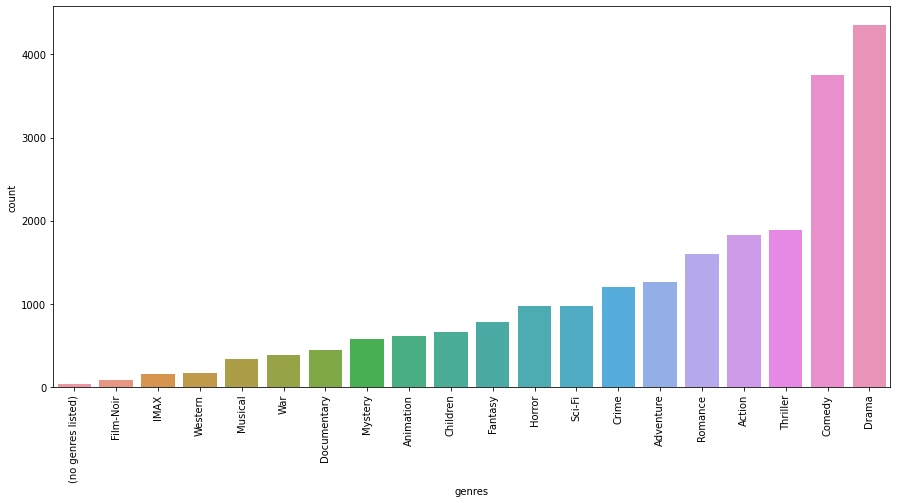

In [11]:
plt.figure(figsize=(15,7))
sns.countplot(data = movies, x = 'genres', order = movies['genres'].value_counts(ascending=True).index)
plt.xticks(rotation=90)
plt.show()

Drama and Comedy are the most common genres found.

### Releases per year

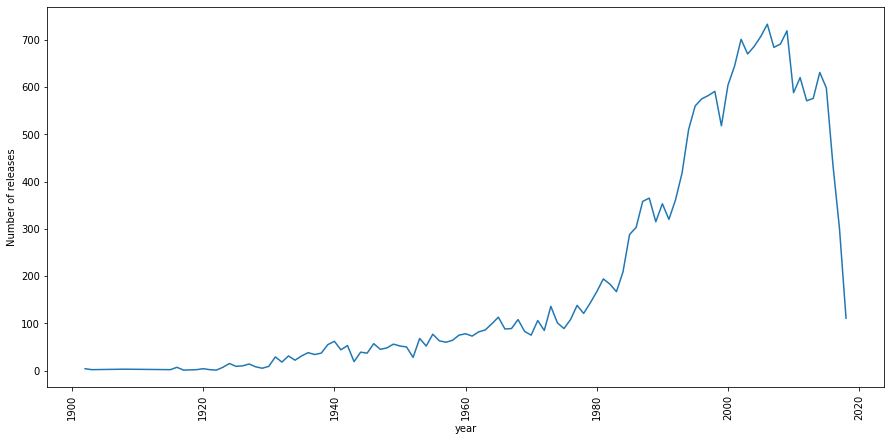

In [12]:
year_df = pd.DataFrame(movies.groupby(['year'])['title'].count().reset_index())

plt.figure(figsize=(15,7))
sns.lineplot(data=year_df, x='year', y='title')

years = range(1900,2021,20)
plt.xticks(rotation=90)
plt.xticks(years)
plt.ylabel('Number of releases')

plt.show()

### Ratings

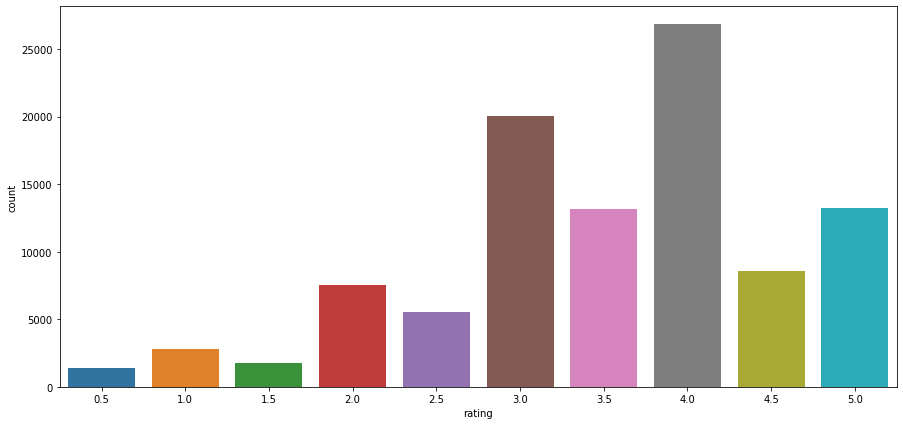

In [13]:
plt.figure(figsize=(15,7))
sns.countplot(data=ratings, x='rating')

plt.show()

In [14]:
pd.DataFrame(ratings['rating'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
rating,100834.0,3.501552,1.042538,0.5,3.0,3.5,4.0,5.0


#### Notes:

* Lowest rating is 0.5
* Most ratings 3 or 4 creating a bimodal distribution 
* Ratings are also slightly skewed left
* Users perceive a 3 out of 5 as below average, 3.5 out of 5 as an average rating, and 4 out of 5 as an above-average rating. 


### Number of Releases per year per genre

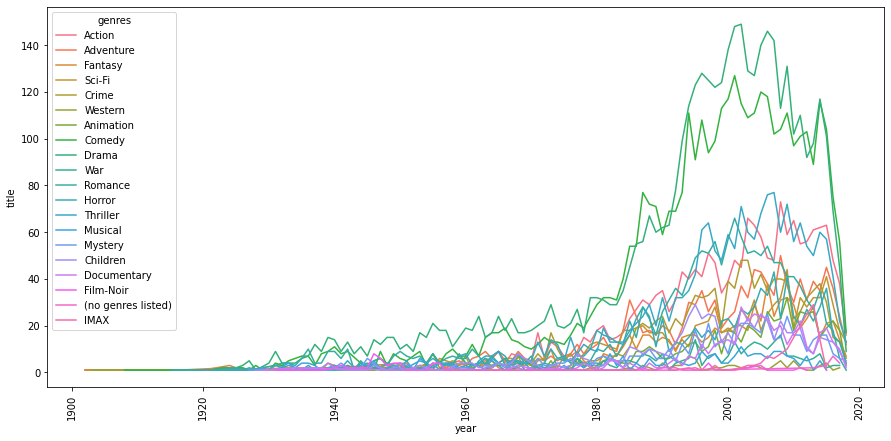

In [15]:
year_genres_df = pd.DataFrame(movies.groupby(['year','genres'])['title'].count().reset_index())
plt.figure(figsize=(15,7))
sns.lineplot(data=year_genres_df, x='year', y='title', hue='genres')

years = range(1900,2021,20)
plt.xticks(rotation=90)
plt.xticks(years)

plt.show()

### Ratings per genre

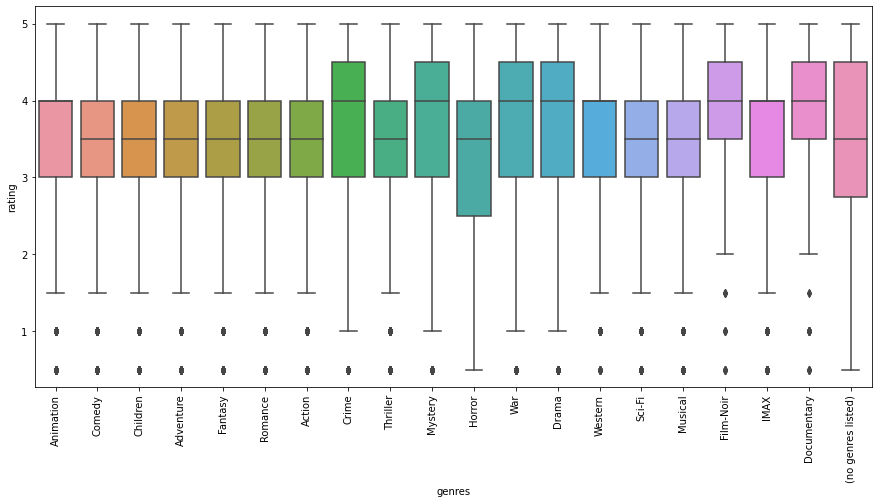

In [16]:
ratings_df = ratings.merge(movies, how='left', on='movieId')

#Drop columns irrelevant for EDA 
ratings_df.drop(['userId','movieId'], axis=1, inplace=True)


#Box plot of genres in ratings data
plt.figure(figsize=(15,7))
sns.boxplot(data = ratings_df, x = 'genres', y = 'rating')
plt.xticks(rotation=90)

plt.show()

#### Notes

* The ratings distributions show higher median ratings for Drama, Mystery, Animation, Film-Noir and Documentary movies, while the Children genre show a more likely tendency of lower ratings.

### Average Ratings

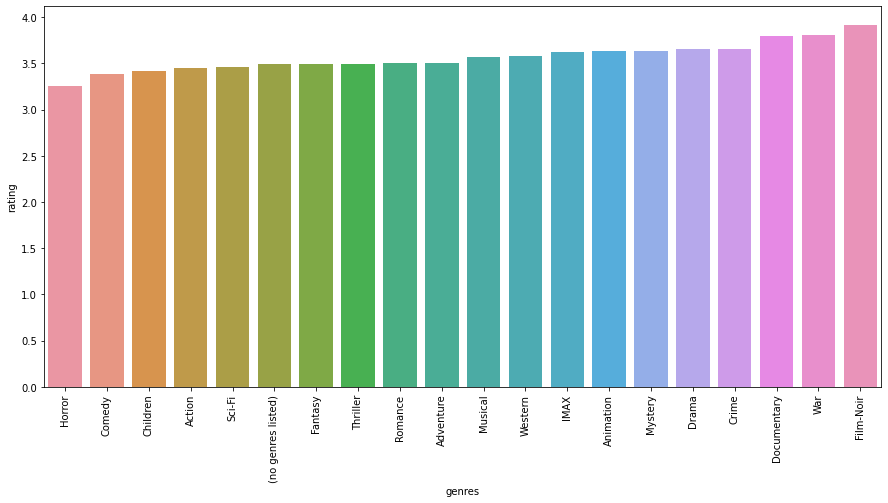

In [17]:
avg_ratings = ratings_df.groupby(['genres'])['rating'].mean().sort_values().reset_index()

plt.figure(figsize=(15,7))
sns.barplot(data = avg_ratings, x='genres',y='rating')
plt.xticks(rotation=90)

plt.show()

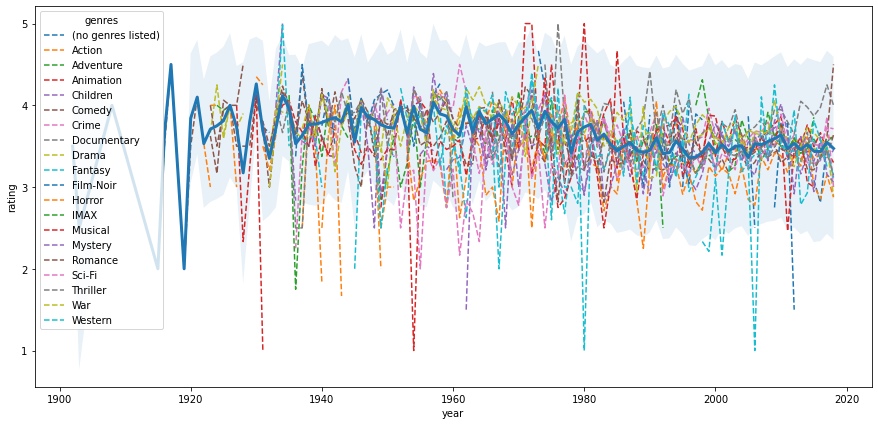

In [18]:
year_mean = ratings_df.groupby(['year'])['rating'].mean()
year_std = ratings_df.groupby(['year'])['rating'].std()
year = list(year_mean.index.sort_values())

ratings_df.groupby(['genres','year'])['rating'].mean().unstack(0).plot(kind='line', figsize=(15, 7), linestyle='dashed')

year_mean.plot(kind='line', linewidth=3)
plt.fill_between(year, year_mean - year_std, year_mean + year_std, alpha=0.1)
plt.ylabel('rating')

plt.show()

There seems to be a general decline in overall ratings over time.

# Data Preparation

In [20]:
#Dataframe of one-hot-encoded genres
genres = pd.get_dummies(movies['genres'])

#Concat 'genres' and 'movies'
movies_ = pd.concat([movies, genres], axis=1)


#Drop 'genres' columns
movies_.drop('genres', axis=1, inplace=True)

#Combine one-hot-encoded genres for each movie, unique by movieId
genres_ = movies_.drop(['title','year'], axis=1).groupby(['movieId']).sum().reset_index()
genres_ = genres_.set_index('movieId')

#Dataframe of unique movies
unique_movies = movies[['movieId','title','year']].drop_duplicates()

#Keep dataframe on unique movies by movieId and title only (exc. year)
unique_movies = unique_movies[['movieId', 'title']]

# * Train test split was used to evaluate the recommenders
# * Cross validation was not used due to the lengthy execution time (excluding model-based filtering).

# A reader is still needed but only the rating_scale param is required
reader = Reader(rating_scale=(0.5, 5))

#Train-test split
trainset, testset = train_test_split(ratings, test_size=0.25, stratify=ratings['userId'])

# A reader required to read rating scale between 0.5 and 5
reader = Reader(rating_scale=(0.5, 5))

# Train and Test Set for SVD
#Train set for surprise (SVD) 
# The columns must correspond to user id, item id and ratings (in that order).
trainset_surprise = Dataset.load_from_df(trainset[['userId', 'movieId', 'rating']], reader)
trainset_surprise = trainset_surprise.build_full_trainset()

#Test set for surprise (SVD)
testset_surprise = list(testset.to_records(index=False))
testset_surprise = [tuple(i)for i in testset_surprise]


#Dataframe containing relevant movies only, i.e. 'truths' are seen as ratings > 3.5 (above overall average)  
threshold = testset[testset['rating']>3.5]
threshold = threshold.sort_values(['userId','rating'], ascending=[True,False])

truths = []
userIds = list(set(ratings['userId']))

for userId in userIds: 
    relevant_ = threshold[threshold['userId']==userId]['movieId'].tolist()
    truths.append(relevant_)

## User-Movie (item) matrix



*   One for the train set [0] and one for the test set [1]
* Not all movies were rated - movieIds of unseen movies in 'missing_movies' 
* Incorporate unrated movies to user-item matrix 




In [21]:
#Make copies and store train and test sets
datasets = [trainset, testset]

#Lists
userIds = list(set(ratings['userId']))
movieIds = list(set(movies['movieId']))

#Set up user-item matrices and store copies
ui_matrix_ = pd.DataFrame(np.nan, index=userIds, columns=movieIds)

train_ui_ = ui_matrix_.copy()
test_ui_ = ui_matrix_.copy()

ui_matrices = [train_ui_, test_ui_]

#Update user-item matrices
#0 = training set
#1 = test set

for i in 0,1:
    dataset_ui_ = pd.pivot_table(datasets[i], values='rating', index=['userId'], columns=['movieId'])
    ui_matrices[i].update(dataset_ui_)

#Preview of training set user-item matrix
train_ui = ui_matrices[0]
print('Preview training set UI Matrix:\n')
print(train_ui.head())
#Preview of test set user-item matrix
test_ui = ui_matrices[1]
print('Preview training set UI Matrix:\n')
print(test_ui.head())
#Check nulls
print('Number of not nulls in blank user-item matrix: ', ui_matrix_.notnull().sum().sum())
print('Number of not nulls in training set user-item matrix: ', ui_matrices[0].notnull().sum().sum())
print('Number of not nulls in test set user-item matrix: ', ui_matrices[1].notnull().sum().sum())
print('Number of ratings in total: ', len(ratings))


Preview training set UI Matrix:

   1      2      3      4      ...  32743  98279  65514  98296
1    NaN    NaN    4.0    NaN  ...    NaN    NaN    NaN    NaN
2    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
3    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
4    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
5    4.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN

[5 rows x 9737 columns]
Preview training set UI Matrix:

   1      2      3      4      ...  32743  98279  65514  98296
1    4.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
2    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
3    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
4    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
5    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN

[5 rows x 9737 columns]
Number of not nulls in blank user-item matrix:  0
Number of not nulls in training set user-item matrix:  75625
Number of not nul

## Boolean Matrices



*   Boolean identifier of training set and ratings to be predicted:

> 1 = rated, 0 = not rated (true ui)
> 1 = not rated, 0 = rated (pred ui)





In [24]:
pred_ui_bool = train_ui_.isnull().astype(float) 
true_ui_bool = 1-pred_ui_bool
print(pred_ui_bool.head())
print(true_ui_bool.head())

   1      2      3      4      ...  32743  98279  65514  98296
1    1.0    1.0    0.0    1.0  ...    1.0    1.0    1.0    1.0
2    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
3    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
4    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
5    0.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0

[5 rows x 9737 columns]
   1      2      3      4      ...  32743  98279  65514  98296
1    0.0    0.0    1.0    0.0  ...    0.0    0.0    0.0    0.0
2    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
3    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
4    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
5    1.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0

[5 rows x 9737 columns]


## User History

In [25]:
user_movies = []
user_ratings = []

for userId in userIds:
    user_ = pd.DataFrame(train_ui_.loc[userId][train_ui_.loc[userId].notnull()])
    user_ = user_.reset_index()
    user_.columns=['movieId', 'rating']
    movies_ = list(user_['movieId'])
    ratings_ = list(user_['rating'])
    
    user_movies.append(movies_)
    user_ratings.append(ratings_)

#Convert lists to dataframe
user_items = pd.DataFrame([userIds, user_movies, user_ratings, truths]).transpose()

#Name columns
user_items.columns=['userId','movieId','rating','actuals']
#Set index
user_items = user_items.set_index('userId')

user_items

,movieId,rating,actuals
userId,,,
1,"[3, 6, 47, 50, 70, 101, 110, 151, 157, 223, 23...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, ...","[216, 362, 3033, 1954, 457, 2571, 2692, 1224, ..."
2,"[333, 131724, 99114, 3578, 71535, 6874, 106782...","[4.0, 5.0, 3.5, 4.0, 3.0, 4.0, 5.0, 3.5, 4.0, ...","[122882, 60756, 68157, 1704, 80489, 79132]"
3,"[527, 647, 688, 849, 914, 1124, 1263, 1275, 13...","[0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 3.5, 0.5, ...","[7991, 70946, 5746, 6835]"
4,"[21, 45, 47, 106, 125, 126, 162, 171, 222, 232...","[3.0, 3.0, 2.0, 4.0, 5.0, 1.0, 5.0, 3.0, 1.0, ...","[1834, 3851, 1967, 2791, 912, 2692, 898, 2174,..."
5,"[1, 21, 34, 36, 50, 58, 110, 150, 232, 247, 25...","[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 4.0, ...","[290, 596, 590, 474, 261, 531]"
...,...,...,...
606,"[1, 7, 11, 15, 18, 29, 32, 36, 46, 47, 50, 58,...","[2.5, 2.5, 2.5, 3.5, 4.0, 4.5, 4.0, 3.5, 4.0, ...","[931, 296, 63082, 7579, 3310, 905, 232, 3083, ..."
607,"[11, 34, 86, 110, 112, 153, 165, 204, 208, 241...","[3.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 3.0, 3.0, ...","[1917, 318, 1997, 736, 150, 2403, 2762, 2268, ..."
608,"[1, 2, 3, 10, 19, 21, 24, 31, 34, 44, 47, 48, ...","[2.5, 2.0, 2.0, 4.0, 2.0, 3.5, 2.0, 3.0, 3.5, ...","[2502, 2028, 4995, 6618, 8970, 16, 6373, 4776,..."


# Modeling



1.   Content-based filtering
2.   Collaborative filtering



## Content-based filtering
* Makes use of item attributes to make recommendation, using movie genre.

In [28]:
user_profiles = []

for index in user_items.index: 
    user_movies = user_items['movieId'][index]
    user_rating = user_items['rating'][index]
    
    #Convert list to array
    user_rating = np.array(user_rating)
    #Convert dataframe to a numpy array
    user_genres = genres_.reset_index()[genres_.reset_index()['movieId'].isin(user_movies)]
    user_genres = user_genres.set_index('movieId')
    user_genres = user_genres.to_numpy()

    #Dot product of arrays to compute user profile
    user_profile = user_rating.dot(user_genres)

    #Convert user profile values between 0 and 1
    profile_sum = sum(user_profile)
    user_profile = [x/profile_sum for x in user_profile]
    
    #Append to 'user_profiles'
    user_profiles.append(user_profile)

#Convert to dataframe of user profiles
user_profiles = pd.DataFrame(user_profiles)

#Compute recommendation scores (between 0 and 1)*

#Create genres matrix (genres x movieIds)
genres_array = genres_.transpose().to_numpy()
#Dot product of user profiles and genres to compute recommendation scores
content_rec = pd.DataFrame(np.dot(user_profiles,genres_array))

content_rec.index = userIds
content_rec.index.name = 'userId'

content_rec.columns = movieIds
content_rec.columns.name = 'movieId'

#Unseen movies (predicted)
print('Predicted unseen movies:\n')
print(pred_ui_bool.head())

#Scores of unseen movies (recommendations only)
rec_scores_df = pred_ui_bool*content_rec
print('Scores of unseen movies:\n')
print(rec_scores_df.head())

#Store ordered recommendations
rec_ordered_scores = []

for userId in userIds:
    rec_ordered_scores_ = list(rec_scores_df.loc[userId].sort_values(ascending=False).index)
    rec_ordered_scores.append(rec_ordered_scores_)

#Convert dataframe to lists for each user
rec_ordered = pd.DataFrame(rec_ordered_scores).values.tolist()

#Store recommendations to new column in user_items
user_items['content_based_rec']=rec_ordered

print(user_items.head())

Predicted unseen movies:

   1      2      3      4      ...  32743  98279  65514  98296
1    1.0    1.0    0.0    1.0  ...    1.0    1.0    1.0    1.0
2    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
3    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
4    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0
5    0.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0

[5 rows x 9737 columns]
Scores of unseen movies:

      1         2         3      ...     98279     65514     98296
1  0.418645  0.259387  0.000000  ...  0.098403  0.174363  0.112214
2  0.149758  0.048309  0.101449  ...  0.234300  0.149758  0.101449
3  0.232779  0.190024  0.047506  ...  0.064133  0.171021  0.038005
4  0.321060  0.106038  0.305596  ...  0.232695  0.063328  0.199558
5  0.000000  0.185083  0.196133  ...  0.204420  0.107735  0.118785

[5 rows x 9737 columns]
                                                  movieId  ...                                  content_based_rec
user

* Movies with more genres tend to be the top recommendations since content-based filtering tend to resolve cold starts.






## Collaborative-based filtering - Model-based


> * Utilizes the ``` Surprise ``` package to conduct SVD, KNNBasic, and KNNwithMeans algorithms to predcit unseen movie ratings.







In [29]:
#SVD, matrix factorisation
svd = SVD()

#KNN user-user collaborative filtering
knn_uu = KNNWithMeans(sim_options = {'name': 'pearson'}, user_based = True)

#KNN item-item collaborative filtering
knn_ii = KNNBasic(sim_options = {'name': 'cosine'}, user_based = False)

surprise_models = [svd, knn_uu, knn_ii]

#Recommendations from surprise 
# Save recommendations
surprise_recs = []

for model in surprise_models: 
    model_recs = surprise_algo(model, trainset_surprise, testset_surprise, userIds)
    surprise_recs.append(model_recs) 

surprise_recs = pd.DataFrame(surprise_recs).transpose()
surprise_recs.index = userIds
surprise_recs.columns = ['SVD_recs', 'KNN_user_user_recs', 'KNN_item_item_recs']


user_items = pd.merge(user_items, surprise_recs, left_index=True, right_index=True)
user_items

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,movieId,rating,actuals,content_based_rec,SVD_recs,KNN_user_user_recs,KNN_item_item_recs
userId,,,,,,,
1,"[3, 6, 47, 50, 70, 101, 110, 151, 157, 223, 23...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, ...","[216, 362, 3033, 1954, 457, 2571, 2692, 1224, ...","[180497, 26171, 178615, 4298, 128852, 74647, 5...","[1, 3147, 923, 2005, 593, 2997, 2571, 1408, 45...","[457, 3147, 1024, 2596, 2761, 1, 1090, 2571, 1...","[2571, 296, 1222, 1291, 3147, 2502, 1, 923, 45..."
2,"[333, 131724, 99114, 3578, 71535, 6874, 106782...","[4.0, 5.0, 3.5, 4.0, 3.0, 4.0, 5.0, 3.5, 4.0, ...","[122882, 60756, 68157, 1704, 80489, 79132]","[180497, 81784, 71530, 1285, 4105, 5771, 122, ...","[318, 1704, 79132, 68157, 80489, 122882, 60756]","[318, 79132, 1704, 122882, 68157, 80489, 60756]","[318, 68157, 79132, 80489, 1704, 122882, 60756]"
3,"[527, 647, 688, 849, 914, 1124, 1263, 1275, 13...","[0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 3.5, 0.5, ...","[7991, 70946, 5746, 6835]","[178615, 44511, 171811, 128852, 172233, 7223, ...","[1272, 720, 1093, 5746, 6835, 31, 6238, 7991, ...","[70946, 5746, 6835, 720, 1272, 7991, 6238, 201...","[1272, 720, 1093, 5746, 6835, 2018, 6238, 31, ..."
4,"[21, 45, 47, 106, 125, 126, 162, 171, 222, 232...","[3.0, 3.0, 2.0, 4.0, 5.0, 1.0, 5.0, 3.0, 1.0, ...","[1834, 3851, 1967, 2791, 912, 2692, 898, 2174,...","[180497, 4105, 4298, 3445, 1642, 5009, 73042, ...","[1136, 912, 1198, 1196, 1219, 2921, 648, 1073,...","[4144, 2921, 1136, 1719, 1198, 1834, 4741, 279...","[176, 2921, 1719, 912, 1198, 898, 1196, 1136, ..."
5,"[1, 21, 34, 36, 50, 58, 110, 150, 232, 247, 25...","[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 4.0, ...","[290, 596, 590, 474, 261, 531]","[4105, 1635, 180497, 122932, 4298, 27370, 5009...","[265, 590, 531, 290, 474, 261, 596, 39, 592, 3...","[265, 590, 531, 261, 474, 596, 290, 592, 344, ...","[590, 265, 261, 290, 474, 592, 596, 531, 39, 3..."
...,...,...,...,...,...,...,...
606,"[1, 7, 11, 15, 18, 29, 32, 36, 46, 47, 50, 58,...","[2.5, 2.5, 2.5, 3.5, 4.0, 4.5, 4.0, 3.5, 4.0, ...","[931, 296, 63082, 7579, 3310, 905, 232, 3083, ...","[4105, 4298, 180497, 6994, 5009, 1642, 3445, 8...","[2959, 4848, 858, 2329, 318, 296, 2318, 1136, ...","[30803, 6345, 7121, 26810, 5915, 943, 1701, 23...","[30803, 6345, 26810, 5915, 7121, 318, 1701, 85..."
607,"[11, 34, 86, 110, 112, 153, 165, 204, 208, 241...","[3.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 3.0, 3.0, ...","[1917, 318, 1997, 736, 150, 2403, 2762, 2268, ...","[180497, 71530, 178615, 4298, 172233, 26171, 4...","[318, 2762, 3363, 1394, 1356, 593, 1207, 1079,...","[188, 318, 1079, 1997, 2268, 150, 1394, 2403, ...","[318, 2762, 589, 593, 1207, 150, 1079, 2791, 1..."
608,"[1, 2, 3, 10, 19, 21, 24, 31, 34, 44, 47, 48, ...","[2.5, 2.0, 2.0, 4.0, 2.0, 3.5, 2.0, 3.0, 3.5, ...","[2502, 2028, 4995, 6618, 8970, 16, 6373, 4776,...","[180497, 4105, 4298, 26171, 71530, 5670, 17861...","[2329, 2502, 3275, 4995, 1350, 32, 1215, 2194,...","[7773, 3275, 741, 50, 4733, 1136, 6104, 1208, ...","[5952, 1089, 50, 2329, 4993, 608, 3275, 4995, ..."


## Evaluation


content_based_rec :  0.012197567004944053
SVD_recs :  0.7012493200376689
KNN_user_user_recs :  0.680704846009442
KNN_item_item_recs :  0.6934258342833187


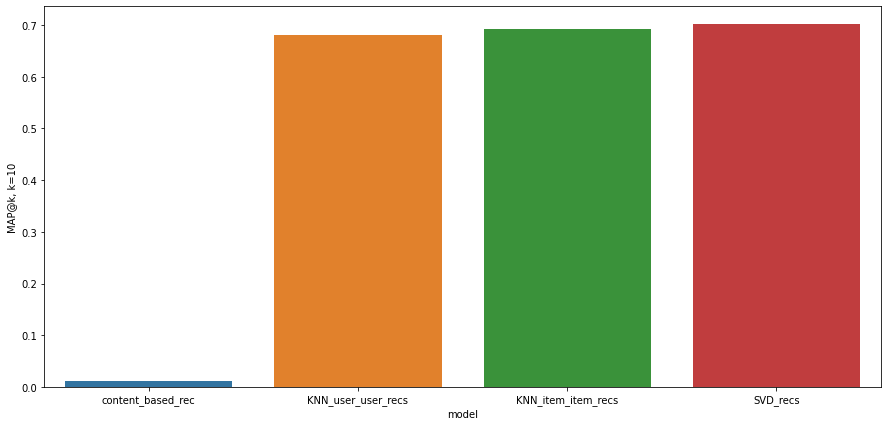

In [30]:
#Take column for user recommendations
rec_cols = user_items.columns[3:]

#Results for Mean Average Precision @ K (MAPk), where K = 10

#Print and store MAPk results
mapk = [] 

for rec in rec_cols: 
    mapk_ = metrics.mapk(user_items['actuals'], user_items[rec], k=10)
    print(rec, ': ', mapk_)
    mapk.append(mapk_)

#Results dataframe
mapk = pd.DataFrame([rec_cols, mapk]).transpose()
mapk.columns = ['model', 'MAP@k, k=10']
mapk = mapk.sort_values('MAP@k, k=10')

#Plot results  
plt.figure(figsize=(15,7))
sns.barplot(data = mapk, x='model', y= 'MAP@k, k=10')

plt.show()

## Results



*   Content-based filtering based on movie genres did not produce a material MAP@k. There is a bias towards movies associated with more genres listed. This recommeder can be improved by adding more attributes. This can include movie cast names, directors, movie tags, etc.
*   Model-based recommenders performed better in terms of MAP@k. This can be attributed to sparsity in the user-item matrix wherein only a selected number of user/item with significant levels of similarities was used during computation.

This is likely due to the algorithms selecting only a number of user/item similarities rather than applying all users/items during computation. Given the sparsity in the user-item matrix, it is likely most users/items show insignificant levels of similarities. 
* The MAP@K, where K = 10, shows the SVD recommender performed the best on the test set, and marginally better than the other algorithms. 


